In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
from tqdm import tqdm
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [3]:
import subsampling as ss
import activity_assembly as actvt
import bout.assembly as bt
import comparison.data_assembly as comp
import comparison.plot as complot
from core import SITE_NAMES

from cli import get_file_paths
import plot
import pipeline

In [4]:
avail = np.arange(0, 180, 2) + 2
reset_3 = avail[np.where((3*60 % avail) == 0)[0]]
reset_4 = avail[np.where((4*60 % avail) == 0)[0]]
reset_6 = avail[np.where((6*60 % avail) == 0)[0]]
reset_12 = avail[np.where((12*60 % avail) == 0)[0]]
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]

In [5]:
dt_starts = {'Carp high':dt.datetime(2022, 7, 15, 3, 0, 0),
             'Carp low':dt.datetime(2022, 9, 15, 0, 0, 0),
           'Telephone high':dt.datetime(2022, 8, 20, 3, 0, 0),
           'Telephone low':dt.datetime(2022, 9, 17, 0, 0, 0),
             'Central':dt.datetime(2022, 7, 10, 0, 0, 0),
             'Foliage':dt.datetime(2022, 7, 10, 0, 0, 0)}
dt_ends = {'Carp high':dt.datetime(2022, 8, 15, 13, 0, 0),
           'Carp low':dt.datetime(2022, 10, 15, 0, 0, 0),
           'Telephone high':dt.datetime(2022, 9, 20, 13, 0, 0),
           'Telephone low':dt.datetime(2022, 10, 17, 13, 0, 0),
           'Central':dt.datetime(2022, 10, 30, 16, 0, 0),
           'Foliage':dt.datetime(2022, 10, 30, 16, 0, 0)}
high_activity_types = {'Carp':'LF', 'Telephone':'HF'}

In [6]:
step = 1/10
step_by = np.arange(step, 1, step)
# step_by = step_by[step_by>=(1/6)]
step_by

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [7]:
step = 1/6
step_by = np.arange(0, (2/3)+step, step)
step_by = step_by[step_by>=(1/6)]
step_by

array([0.16666667, 0.33333333, 0.5       , 0.66666667])

In [8]:
cycle_lengths = [6, 10, 30, 48, 60, 72, 90]
percent_ons = step_by
data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(cycle_lengths, percent_ons)
dc_tags

['30of30',
 '1of6',
 '2of6',
 '3of6',
 '4of6',
 '2of10',
 '3of10',
 '5of10',
 '7of10',
 '5of30',
 '10of30',
 '15of30',
 '20of30',
 '8of48',
 '16of48',
 '24of48',
 '32of48',
 '10of60',
 '20of60',
 '30of60',
 '40of60',
 '12of72',
 '24of72',
 '36of72',
 '48of72',
 '15of90',
 '30of90',
 '45of90',
 '60of90']

In [9]:
site_keys = ['Carp']
type_keys = ['LF']
data_params["dc_tags"] = dc_tags
data_params['cur_dc_tag'] = '30of30'
data_params['metric_tag'] = 'bout_time_percentage'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['assembly_type'] = 'kmeans'

In [10]:
def add_noise_to_group(group, frac):
    noise_start_times = np.random.uniform(0, 1800, np.floor(frac*group.shape[0]).astype(int))
    noise_df = pd.DataFrame()
    noise_df['start_time'] = noise_start_times
    noise_df['end_time'] = noise_start_times + 0.01
    noise_df['low_freq'] = [24000]*noise_df.shape[0]
    noise_df['high_freq'] = [30000]*noise_df.shape[0]
    noise_df['class'] = ['NOISE']*noise_df.shape[0]

    added_noise_hf_file_dets = pd.concat([group, noise_df])
    file_dts = pd.to_datetime(added_noise_hf_file_dets['input_file'], format='%Y%m%d_%H%M%S', exact=False).ffill().bfill()

    anchor_start_times = file_dts + pd.to_timedelta(added_noise_hf_file_dets['start_time'].values.astype('float64'), unit='S')
    anchor_end_times = file_dts + pd.to_timedelta(added_noise_hf_file_dets['end_time'].values.astype('float64'), unit='S') 
    added_noise_hf_file_dets['call_end_time'] = anchor_end_times
    added_noise_hf_file_dets['call_start_time'] = anchor_start_times
    added_noise_hf_file_dets['ref_time'] = anchor_start_times
    added_noise_hf_file_dets = added_noise_hf_file_dets.sort_values(by='call_start_time')

    return added_noise_hf_file_dets

In [11]:
def generate_activity_btp_for_dc_schemes_and_cont_for_false_positives(data_params, file_paths, save=False):
    activity_arr = pd.DataFrame()
    location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["detector_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
    bout_params = bt.get_bout_params_from_location(location_df, data_params)

    dc_tag = '30of30'
    metric_col_name = f'{data_params["metric_tag"]} ({dc_tag})'
    btp_cont_column = comp.get_continuous_btp_partitioned_for_dc_scheme(metric_col_name, location_df.copy(), data_params, bout_params)
    fractions = np.arange(0.0, 0.11, 0.01)
    for i in tqdm(range(len(fractions))):
        frac = fractions[i]
        data_params['cur_dc_tag'] = dc_tag
        cycle_length_in_mins = int(data_params['cur_dc_tag'].split('of')[1])
        time_on_in_mins = int(data_params['cur_dc_tag'].split('of')[0])
        time_on_in_secs = (60*time_on_in_mins)

        added_noise_location_df = location_df.groupby(by='input_file_dt', group_keys=False).apply(lambda x : add_noise_to_group(x, frac))
        dc_applied_df = ss.simulate_dutycycle_on_detections(added_noise_location_df.copy(), data_params)
        dc_applied_df['freq_group'] = ['LF']*dc_applied_df.shape[0]
        # comp.does_duty_cycled_df_have_less_dets_than_original(dc_applied_df_reduced, location_df)
        bout_metrics = bt.generate_bout_metrics_for_location_and_freq(dc_applied_df, data_params, bout_params)
        bout_duration = actvt.get_bout_duration_per_cycle(bout_metrics, cycle_length_in_mins)
        bout_time_percentage = actvt.get_btp_per_time_on(bout_duration, time_on_in_secs)
        data_params['cur_dc_tag'] = f'{round(frac, 2)}'
        bout_time_percentage_dc_column = actvt.filter_and_prepare_metric(bout_time_percentage, data_params)
        bout_time_percentage_dc_column = bout_time_percentage_dc_column.set_index("datetime_UTC")
        ss.are_there_expected_number_of_cycles(dc_applied_df, bout_time_percentage_dc_column, cycle_length_in_mins, data_params)

        activity_arr = pd.concat([activity_arr, bout_time_percentage_dc_column], axis=1)

    return activity_arr, btp_cont_column

In [12]:
site_key = site_keys[0]
type_key = type_keys[0]
print(site_key, type_key)
data_params["site_tag"] = site_key
data_params["site_name"] = SITE_NAMES[site_key]
data_params["type_tag"] = type_key
data_params["detector_tag"] = 'bd2'
file_paths = get_file_paths(data_params)

activitybout_arr, btp_arr = generate_activity_btp_for_dc_schemes_and_cont_for_false_positives(data_params, file_paths, save=True)

Carp LF


100%|██████████| 11/11 [03:31<00:00, 19.25s/it]


In [13]:
activitybout_arr

,bout_time_percentage (0.0),bout_time_percentage (0.01),bout_time_percentage (0.02),bout_time_percentage (0.03),bout_time_percentage (0.04),bout_time_percentage (0.05),bout_time_percentage (0.06),bout_time_percentage (0.07),bout_time_percentage (0.08),bout_time_percentage (0.09),bout_time_percentage (0.1)
datetime_UTC,,,,,,,,,,,
2022-07-13 04:30:00,0.780906,0.780906,0.780906,0.780906,0.780906,0.780906,0.780906,0.780906,0.780906,0.780906,0.780906
2022-07-13 05:00:00,1.239528,1.239528,1.239528,1.239528,1.239528,1.239528,1.239528,1.239528,1.239528,1.239528,1.239528
2022-07-13 05:30:00,6.021417,6.021417,6.021417,6.021417,6.021417,6.021417,6.540919,6.282025,6.235257,6.159643,6.264248
2022-07-13 06:00:00,2.787056,2.787056,2.787056,2.798605,2.927963,2.787056,2.787056,2.787056,2.787056,2.787056,2.799705
2022-07-13 06:30:00,1.464528,1.464528,1.464528,1.464528,1.464528,1.464528,1.464528,1.644216,1.464528,1.464528,1.464528
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-17 11:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-10-17 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-10-17 12:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
type_key = high_activity_types[site_key]
actvt_key = 'high'
data_params['start'] = dt_starts[f'{site_key} {actvt_key}']
data_params['end'] = dt_ends[f'{site_key} {actvt_key}']

In [39]:
def get_percent_points_in_bounds_log(plt_dcmetr, plt_cmetr, p, upb):
    points_dc = pd.DataFrame(plt_dcmetr.values, columns=['values'], index=plt_dcmetr.index)
    points_c = pd.DataFrame(plt_cmetr.values, columns=['values'], index=plt_cmetr.index)
    points_c = points_c[points_c!=0].dropna()
    points_dc = points_dc.loc[points_c.index]
    total_num_points = points_dc.shape[0]

    axis = 1
    within_bounds = ((points_dc.values<=points_c.values*(axis+(upb*p)))&(points_dc.values>=points_c.values*(axis-p)))
    num_points_in_bounds = np.sum(within_bounds.astype(int), axis=0)
    percent_points_in_bounds = num_points_in_bounds / total_num_points
    # all_points_bound = p[percent_points_in_bounds==1][0]

    # test_true_100_at_factor(points_dc, points_c, all_points_bound)

    return percent_points_in_bounds

def plot_percent_within_bounds_curve_for_metric(plt_dc_metr, plt_c_metr, data_params):
    frac = float(re.findall(r"(\d.\d+)", plt_dc_metr.columns[0])[0])
    plt.title(f'Samples added ({int(100*frac)}%)')
    p = np.arange(0, 10, 0.01) + 1e-14
    p_inds = np.where(np.isclose(p, data_params['P'], atol=1e-6))[0][0]
    percent_points_in_bounds = get_percent_points_in_bounds_log(plt_dc_metr, plt_c_metr, p, 1.0)

    if data_params['metric_tag']=='call_rate':
        col = 'red'
    elif data_params['metric_tag']=='activity_index':
        col = 'royalblue'
    else:
        col = 'green'

    points_on_line = percent_points_in_bounds[p_inds]
    plt.plot(100*p, 100*percent_points_in_bounds, label=f'{round(100*points_on_line)}% captured',
                color=col, linewidth=3, alpha=0.8)

    # plt.axvline(x=100*data_params['P'],linestyle='dashed', color='k', linewidth=2, alpha=0.5) 
    # plt.axhline(y=100*points_on_line,linestyle='dashed', color='k', linewidth=2, alpha=0.5) 
    plt.xlabel('% truth from line-of-unity')
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.ylabel('% of samples captured')
    # plt.legend(loc=4, fontsize=16)
    plt.grid(which='both')

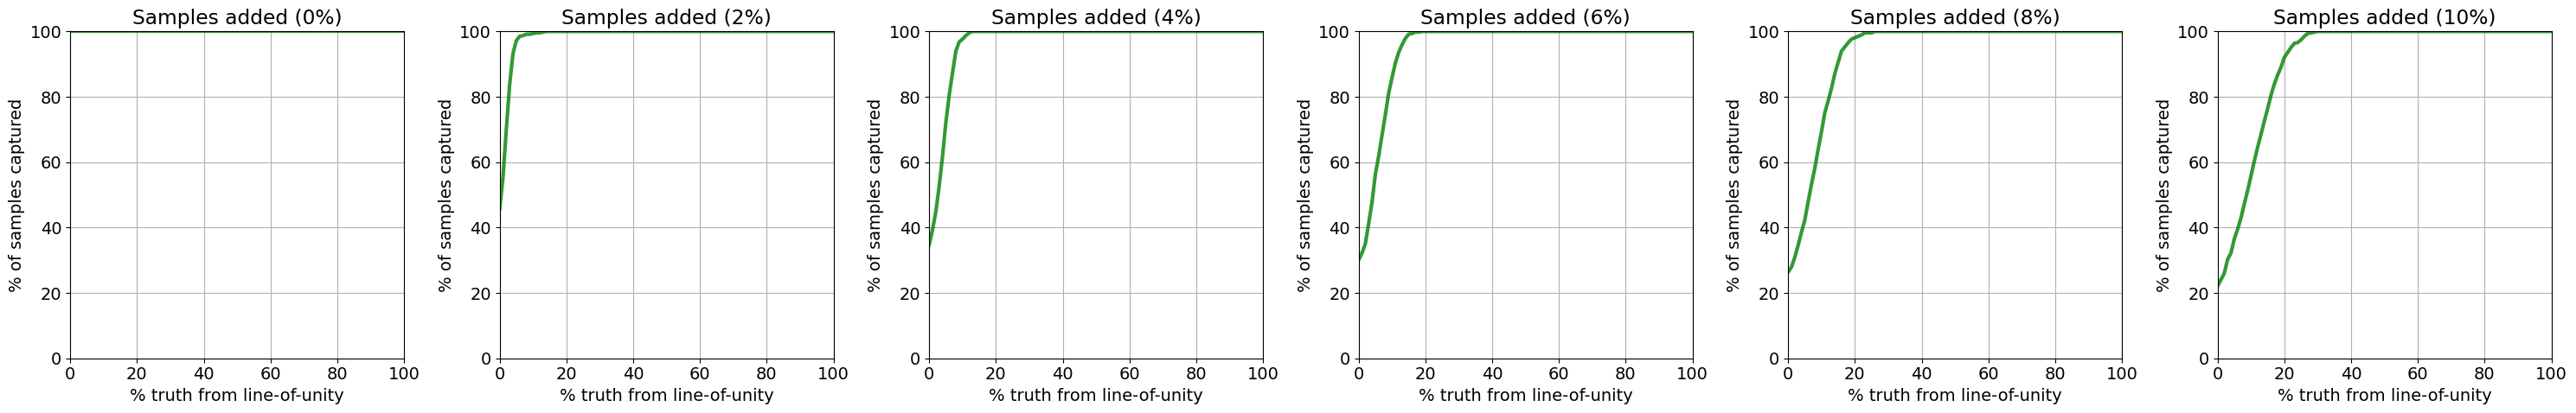

In [43]:
import pytz

data_params['metric_tag'] = 'bout_time_percentage'
data_params['index_time_block_in_secs'] = '5'
activitybout_arr.index = pd.DatetimeIndex(activitybout_arr.index)
btp_arr.index = pd.DatetimeIndex(btp_arr.index)
UBNA_tz = pytz.timezone('US/Pacific')
UTC_tz = pytz.timezone('UTC')
data_params['P'] = 0.20

plt.figure(figsize=(30, 5))
plt.rcParams.update({'font.size':14})
for i, dc_col in enumerate(np.arange(0, 0.11, 0.02)):
    plt.subplot(1, 6, i+1)
    metric_col_name = f'{data_params["metric_tag"]} ({round(dc_col,2)})'
    cont_tag = f'30of30'
    cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
    metric_for_scheme = pd.DataFrame(activitybout_arr.loc[:,metric_col_name].dropna())
    cont_column = pd.DataFrame(btp_arr.loc[:,cont_metric_col_name].dropna())
    metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
    plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
    plot_percent_within_bounds_curve_for_metric(plt_dcmetr, plt_cmetr, data_params)

plt.tight_layout()
plt.show()

In [30]:
def plot_indiv_dc_control_comp_over_cycle_linear_scale(single_col_dc_metr1, single_col_c_metr, data_params):
    single_col_dc_metr1.index = pd.DatetimeIndex(single_col_dc_metr1.index)
    dc_metr1 = pd.pivot_table(single_col_dc_metr1, index=(single_col_dc_metr1.index.time), 
                        columns=single_col_dc_metr1.index.date, 
                        values=single_col_dc_metr1.columns[0])
    single_col_c_metr.index = pd.DatetimeIndex(single_col_c_metr.index)
    paired_col_c_metr = single_col_c_metr[(~single_col_dc_metr1.isna()).values]
    c_metr = pd.pivot_table(paired_col_c_metr, index=(paired_col_c_metr.index.time), 
                    columns=paired_col_c_metr.index.date, 
                    values=paired_col_c_metr.columns[0])
    plt.grid(which='both')
    if data_params['metric_tag']=='call_rate':
        col = 'red'
        units = 'calls/min'
    elif data_params['metric_tag']=='activity_index':
        col = 'royalblue'
        units = '%'
    else:
        col = 'green'
        units = '%'
    frac = float(re.findall(r"\d.\d+", single_col_dc_metr1.columns[0])[0])
    c_metr_max = c_metr.max().max()
    plt.plot([0, 100*c_metr_max], [0, 100*c_metr_max], linestyle='dashed', color='k', label='line-of-unity')
    
    plt.title(f'Samples kept ({int(100*frac)}%)')
    plt.scatter(c_metr, dc_metr1, color=col, edgecolors='k', s=80, alpha=0.8)
    plt.xlabel(f'True values ({units})')
    plt.ylabel(f'Reduced estimate ({units})')
    upper_lim = 400
    if (data_params['metric_tag'] == 'call_rate'):
        plt.xlim(0, upper_lim)
        plt.ylim(0, upper_lim)
    else:
        plt.xlim(0, 100)
        plt.ylim(0, 100)
        plt.xticks(np.arange(0, 110, 20))
        plt.yticks(np.arange(0, 110, 20))

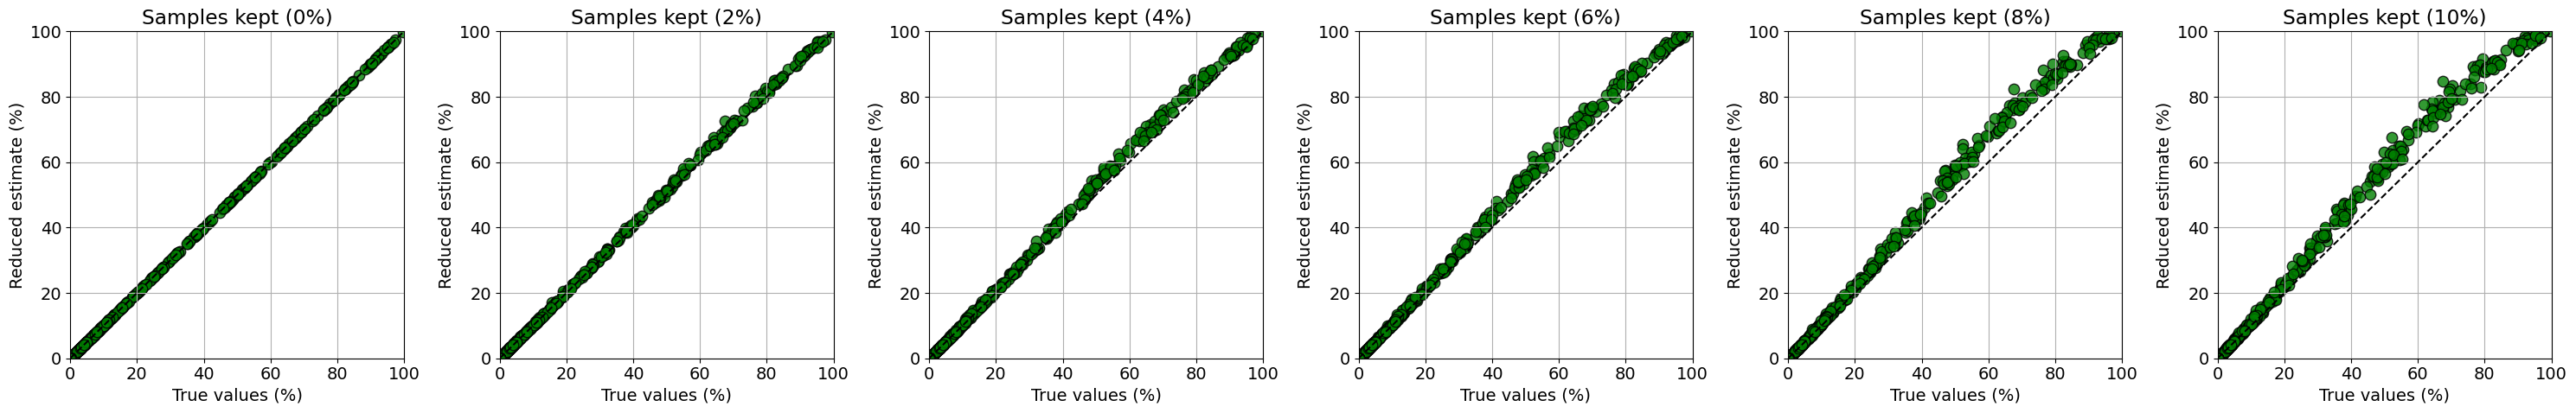

In [31]:
plt.figure(figsize=(30, 5))
plt.rcParams.update({'font.size':14})
for i, dc_col in enumerate(np.arange(0, 0.11, 0.02)):
    plt.subplot(1, 6, i+1)
    metric_col_name = f'{data_params["metric_tag"]} ({round(dc_col,2)})'
    cont_tag = f'30of30'
    cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
    metric_for_scheme = pd.DataFrame(activitybout_arr.loc[:,metric_col_name].dropna())
    cont_column = pd.DataFrame(btp_arr.loc[:,cont_metric_col_name].dropna())
    metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
    plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
    plot_indiv_dc_control_comp_over_cycle_linear_scale(plt_dcmetr, plt_cmetr, data_params)

plt.tight_layout()
plt.show()

In [19]:
def generate_activity_call_rate_for_dc_schemes_and_cont_for_false_negatives(data_params, file_paths, save=False):
    activity_arr = pd.DataFrame()
    location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["detector_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)

    dc_tag = '30of30'
    metric_col_name = f'{data_params["metric_tag"]} ({dc_tag})'
    callrate_arr = comp.get_continuous_call_rates_partitioned_for_dc_scheme(metric_col_name, file_paths, data_params)
    fractions = np.arange(0, 0.11, 0.01)
    for i in tqdm(range(len(fractions))):
        frac = fractions[i]
        data_params['cur_dc_tag'] = dc_tag
        cycle_length_in_mins = int(data_params['cur_dc_tag'].split('of')[1])
        time_on_in_mins = int(data_params['cur_dc_tag'].split('of')[0])

        added_noise_location_df = location_df.groupby(by='input_file_dt', group_keys=False).apply(lambda x : add_noise_to_group(x, frac))
        dc_applied_df = ss.simulate_dutycycle_on_detections(added_noise_location_df.copy(), data_params)
        dc_applied_df['freq_group'] = ['LF']*dc_applied_df.shape[0]
        # comp.does_duty_cycled_df_have_less_dets_than_original(dc_applied_df_reduced, location_df)
        num_of_detections = actvt.get_number_of_detections_per_cycle(dc_applied_df, cycle_length_in_mins)        
        call_rate = actvt.get_metric_per_time_on(num_of_detections, time_on_in_mins)
        data_params['cur_dc_tag'] = f'{round(frac, 2)}'
        call_rate_dc_column = actvt.filter_and_prepare_metric(call_rate, data_params)
        call_rate_dc_column = call_rate_dc_column.set_index("datetime_UTC")
        ss.are_there_expected_number_of_cycles(dc_applied_df, call_rate_dc_column, cycle_length_in_mins, data_params)
        
        activity_arr = pd.concat([activity_arr, call_rate_dc_column], axis=1)

    return activity_arr, callrate_arr

In [20]:
data_params['metric_tag'] = 'call_rate'

In [21]:
print(site_key, type_key)
data_params["site_tag"] = site_key
data_params["site_name"] = SITE_NAMES[site_key]
data_params["type_tag"] = type_key
data_params["detector_tag"] = 'bd2'
file_paths = get_file_paths(data_params)

activitycallrate_arr, callrate_arr = generate_activity_call_rate_for_dc_schemes_and_cont_for_false_negatives(data_params, file_paths, save=True)

Carp LF


100%|██████████| 11/11 [01:23<00:00,  7.60s/it]


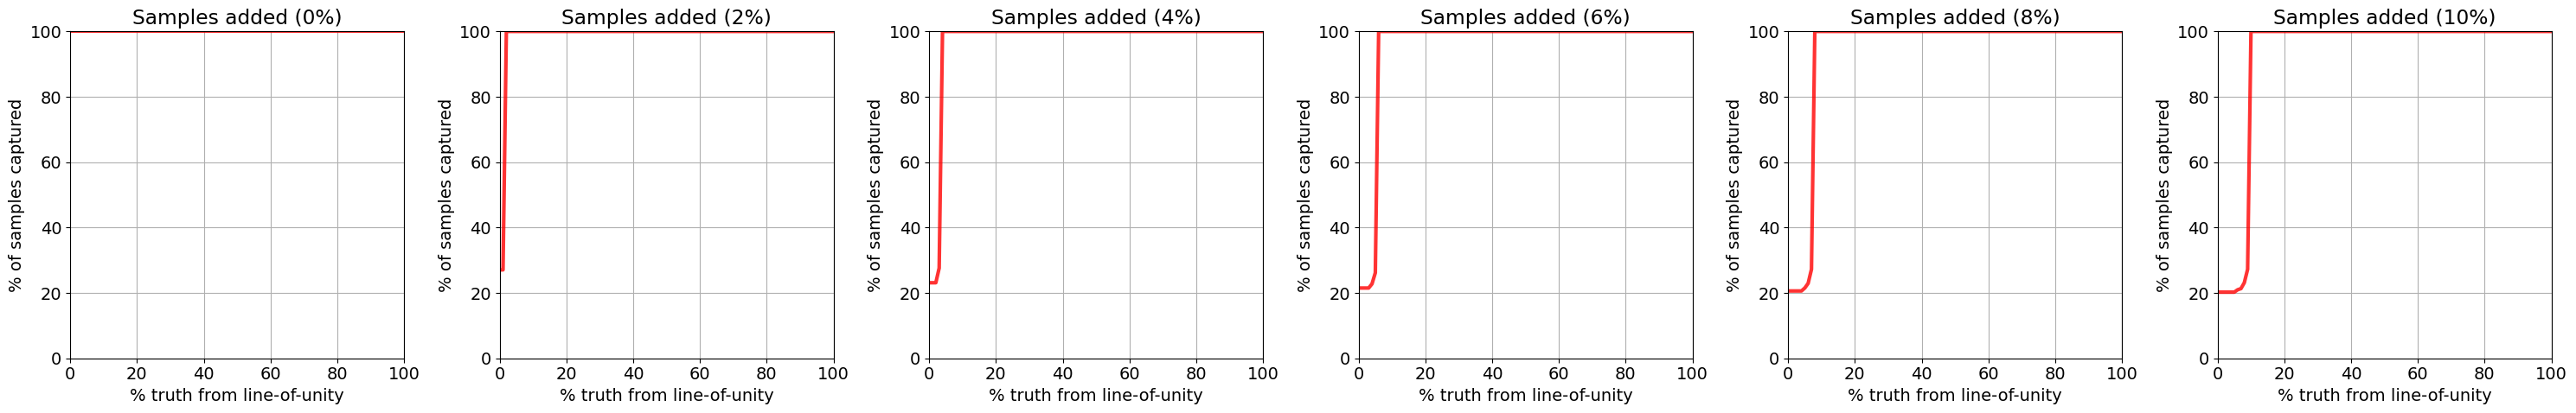

In [44]:
import pytz

data_params['metric_tag'] = 'call_rate'
data_params['index_time_block_in_secs'] = '5'
activitycallrate_arr.index = pd.DatetimeIndex(activitycallrate_arr.index)
callrate_arr.index = pd.DatetimeIndex(callrate_arr.index)
UBNA_tz = pytz.timezone('US/Pacific')
UTC_tz = pytz.timezone('UTC')
data_params['P'] = 0.20

plt.figure(figsize=(30, 5))
plt.rcParams.update({'font.size':14})
for i, dc_col in enumerate(np.arange(0, 0.11, 0.02)):
    plt.subplot(1, 6, i+1)
    metric_col_name = f'{data_params["metric_tag"]} ({round(dc_col,2)})'
    cont_tag = f'30of30'
    cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
    metric_for_scheme = pd.DataFrame(activitycallrate_arr.loc[:,metric_col_name].dropna())
    cont_column = pd.DataFrame(callrate_arr.loc[:,cont_metric_col_name].dropna())
    metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
    plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
    plot_percent_within_bounds_curve_for_metric(plt_dcmetr, plt_cmetr, data_params)

plt.tight_layout()
plt.show()

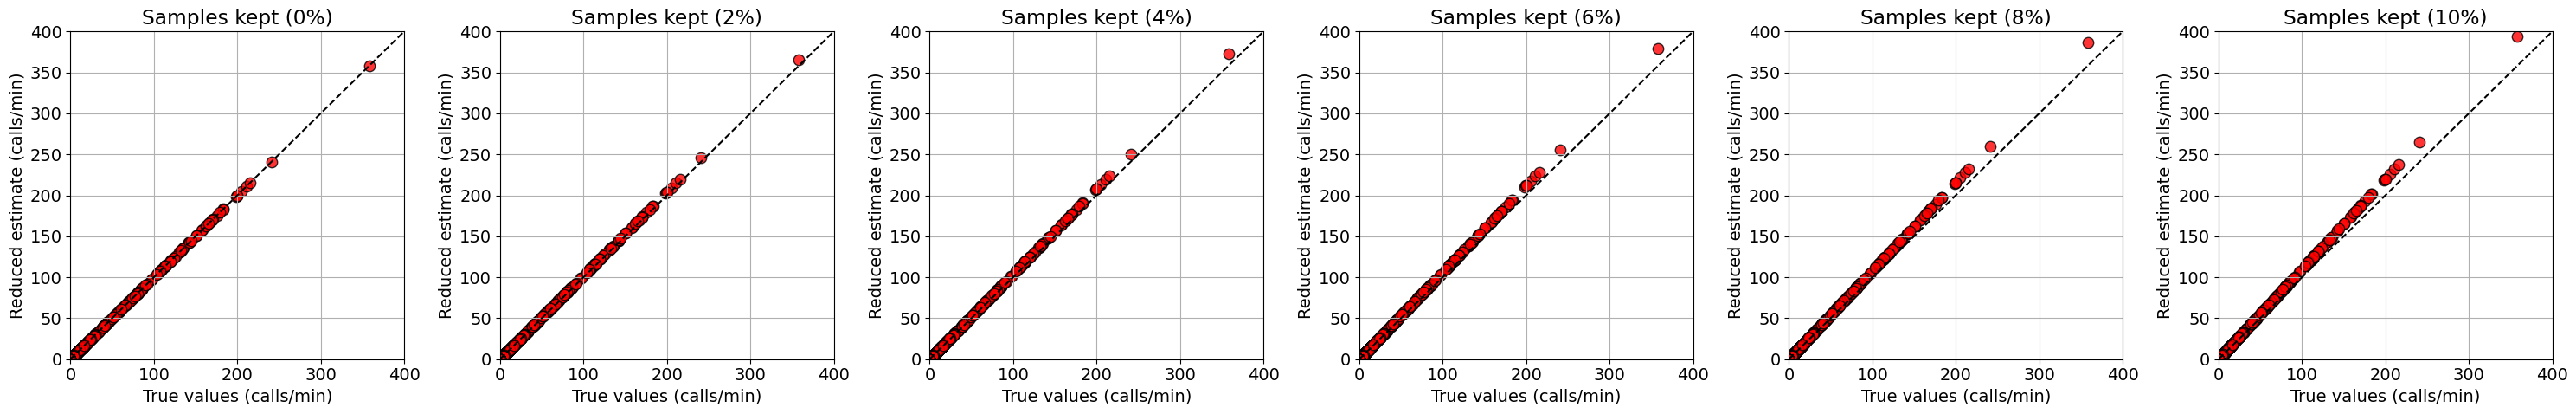

In [34]:
plt.figure(figsize=(30, 5))
plt.rcParams.update({'font.size':14})
for i, dc_col in enumerate(np.arange(0, 0.11, 0.02)):
    plt.subplot(1, 6, i+1)
    metric_col_name = f'{data_params["metric_tag"]} ({round(dc_col,2)})'
    cont_tag = f'30of30'
    cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
    metric_for_scheme = pd.DataFrame(activitycallrate_arr.loc[:,metric_col_name].dropna())
    cont_column = pd.DataFrame(callrate_arr.loc[:,cont_metric_col_name].dropna())
    metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
    plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
    plot_indiv_dc_control_comp_over_cycle_linear_scale(plt_dcmetr, plt_cmetr, data_params)

plt.tight_layout()
plt.show()

In [24]:
data_params['metric_tag'] = 'activity_index'
data_params['index_time_block_in_secs'] = 5

In [35]:
def generate_activity_index_percent_for_dc_schemes_and_cont_for_false_negatives(data_params, file_paths, save=False):
    activity_arr = pd.DataFrame()
    location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["detector_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)

    dc_tag = '30of30'
    metric_col_name = f'{data_params["metric_tag"]} ({dc_tag})'
    actvtind_cont_column = comp.get_continuous_activity_index_partitioned_for_dc_scheme(metric_col_name, file_paths, data_params)
    fractions = np.arange(0, 0.11, 0.01)
    for i in tqdm(range(len(fractions))):
        frac = fractions[i]
        data_params['cur_dc_tag'] = dc_tag
        cycle_length_in_mins = int(data_params['cur_dc_tag'].split('of')[1])

        added_noise_location_df = location_df.groupby(by='input_file_dt', group_keys=False).apply(lambda x : add_noise_to_group(x, frac))
        dc_applied_df = ss.simulate_dutycycle_on_detections(added_noise_location_df.copy(), data_params)
        dc_applied_df['freq_group'] = ['LF']*dc_applied_df.shape[0]
        # comp.does_duty_cycled_df_have_less_dets_than_original(dc_applied_df_reduced, location_df)
        num_blocks_of_presence = actvt.get_activity_index_per_cycle(dc_applied_df, data_params)        
        activity_ind_percent = actvt.get_activity_index_per_time_on_index(num_blocks_of_presence, data_params)
        data_params['cur_dc_tag'] = f'{round(frac, 2)}'
        ind_percent_dc_column = actvt.filter_and_prepare_metric(activity_ind_percent, data_params)
        ind_percent_dc_column = ind_percent_dc_column.set_index("datetime_UTC")
        ss.are_there_expected_number_of_cycles(dc_applied_df, ind_percent_dc_column, cycle_length_in_mins, data_params)
        
        activity_arr = pd.concat([activity_arr, ind_percent_dc_column], axis=1)

    return activity_arr, actvtind_cont_column

In [26]:
print(site_key, type_key)
data_params["site_tag"] = site_key
data_params["site_name"] = SITE_NAMES[site_key]
data_params["type_tag"] = type_key
data_params["detector_tag"] = 'bd2'
file_paths = get_file_paths(data_params)

activityind_arr, actvtind_arr = generate_activity_index_percent_for_dc_schemes_and_cont_for_false_negatives(data_params, file_paths, save=True)

Carp LF


100%|██████████| 11/11 [01:16<00:00,  6.96s/it]


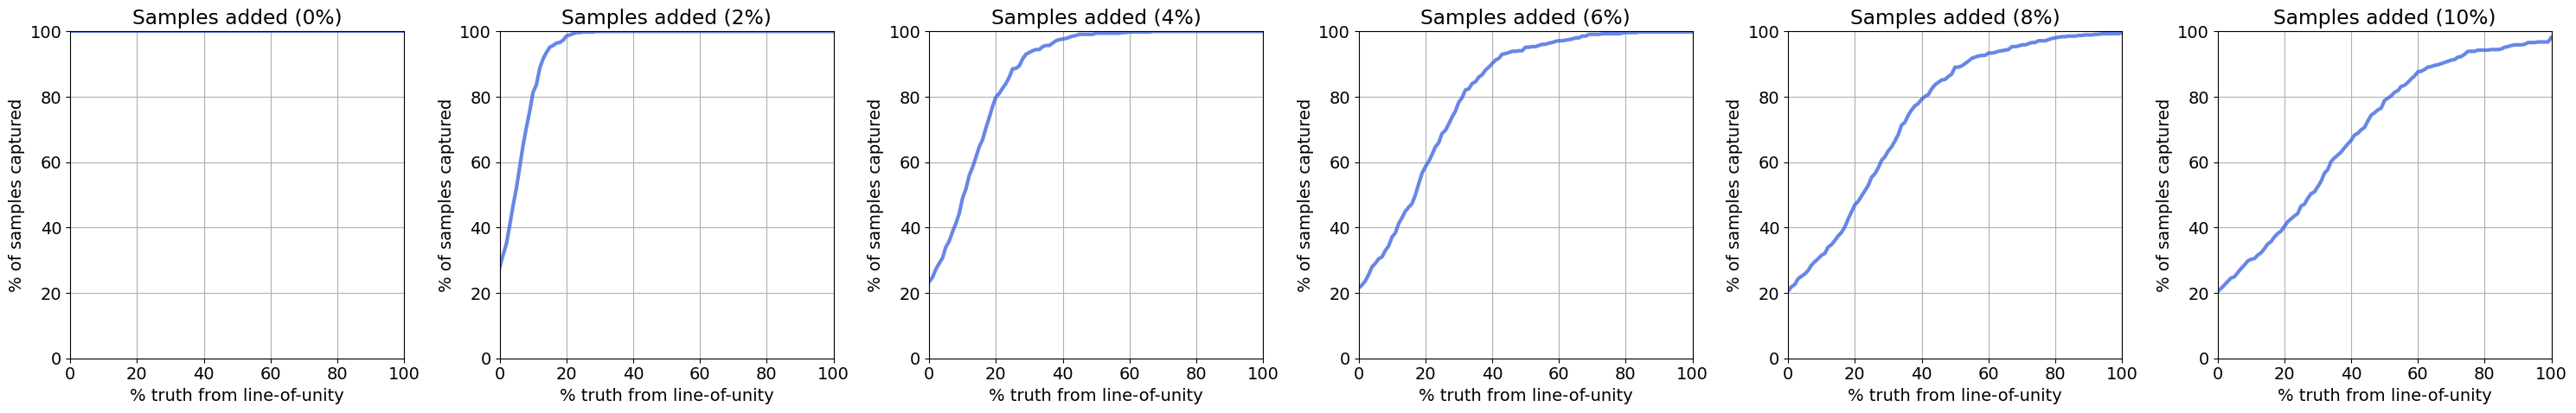

In [45]:
import pytz

data_params['metric_tag'] = 'activity_index'
data_params['index_time_block_in_secs'] = '5'
activityind_arr.index = pd.DatetimeIndex(activityind_arr.index)
actvtind_arr.index = pd.DatetimeIndex(actvtind_arr.index)
UBNA_tz = pytz.timezone('US/Pacific')
UTC_tz = pytz.timezone('UTC')
data_params['P'] = 0.20

plt.figure(figsize=(30, 5))
plt.rcParams.update({'font.size':14})
for i, dc_col in enumerate(np.arange(0, 0.11, 0.02)):
    plt.subplot(1, 6, i+1)
    metric_col_name = f'{data_params["metric_tag"]} ({round(dc_col,2)})'
    cont_tag = f'30of30'
    cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
    metric_for_scheme = pd.DataFrame(activityind_arr.loc[:,metric_col_name].dropna())
    cont_column = pd.DataFrame(actvtind_arr.loc[:,cont_metric_col_name].dropna())
    metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
    plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
    plot_percent_within_bounds_curve_for_metric(plt_dcmetr, plt_cmetr, data_params)

plt.tight_layout()
plt.show()

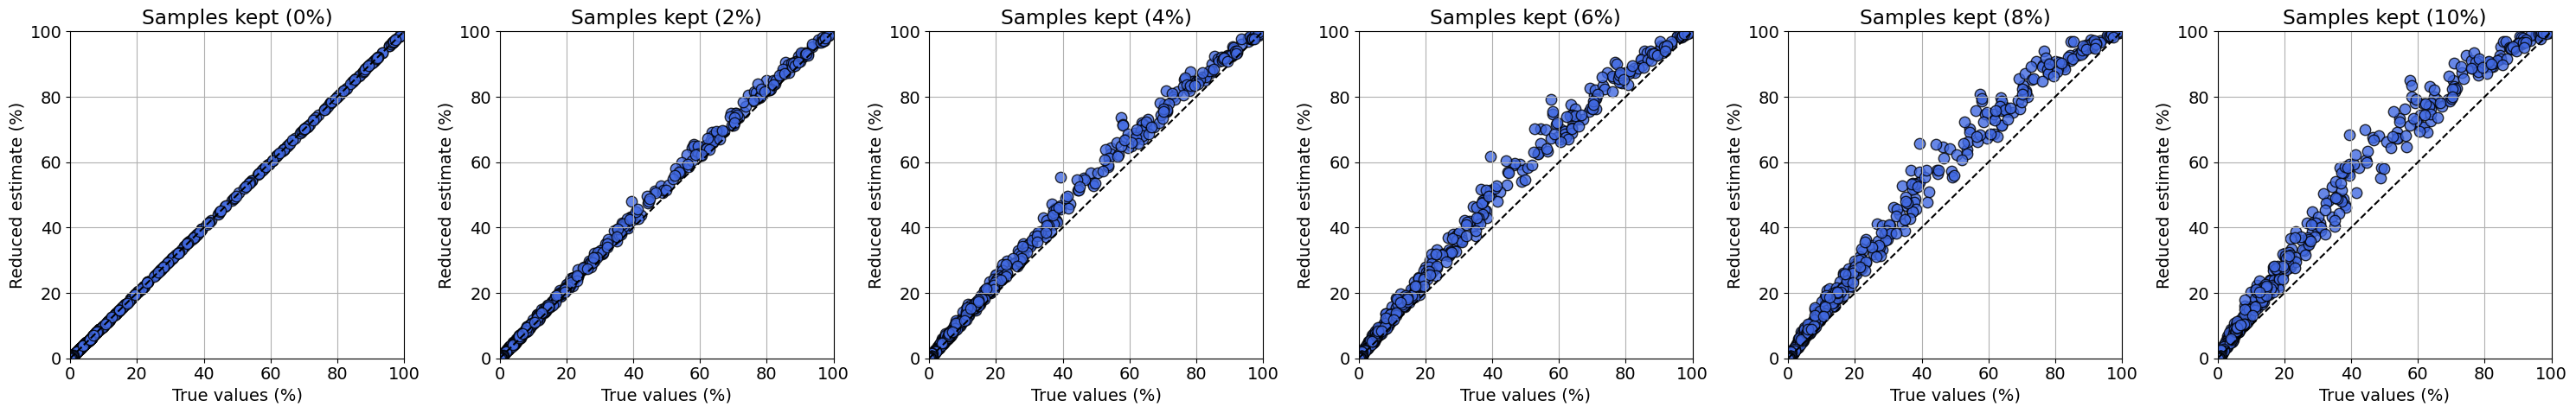

In [37]:
plt.figure(figsize=(30, 5))
plt.rcParams.update({'font.size':14})
for i, dc_col in enumerate(np.arange(0, 0.11, 0.02)):
    plt.subplot(1, 6, i+1)
    metric_col_name = f'{data_params["metric_tag"]} ({round(dc_col,2)})'
    cont_tag = f'30of30'
    cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
    metric_for_scheme = pd.DataFrame(activityind_arr.loc[:,metric_col_name].dropna())
    cont_column = pd.DataFrame(actvtind_arr.loc[:,cont_metric_col_name].dropna())
    metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
    plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
    plot_indiv_dc_control_comp_over_cycle_linear_scale(plt_dcmetr, plt_cmetr, data_params)

plt.tight_layout()
plt.show()

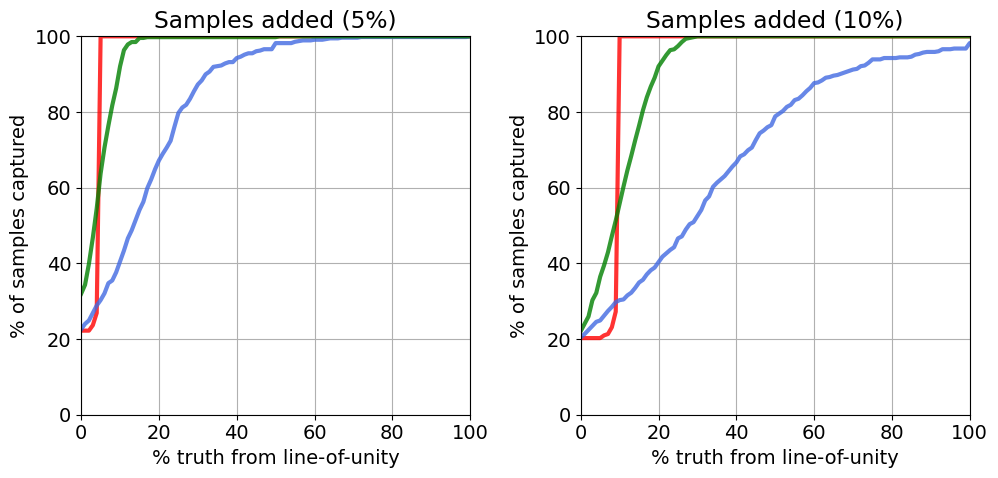

In [47]:
plt.figure(figsize=(30, 5))
plt.rcParams.update({'font.size':14})
for i, dc_col in enumerate(np.array([0.05, 0.1])):
    plt.subplot(1, 6, i+1)
    data_params['metric_tag'] = 'call_rate'
    data_params['index_time_block_in_secs'] = 5
    metric_col_name = f'{data_params["metric_tag"]} ({round(dc_col,2)})'
    cont_tag = f'30of30'
    cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
    metric_for_scheme = pd.DataFrame(activitycallrate_arr.loc[:,metric_col_name].dropna())
    cont_column = pd.DataFrame(callrate_arr.loc[:,cont_metric_col_name].dropna())
    metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
    plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
    plot_percent_within_bounds_curve_for_metric(plt_dcmetr, plt_cmetr, data_params)

    data_params['metric_tag'] = 'activity_index'
    data_params['index_time_block_in_secs'] = 5
    metric_col_name = f'{data_params["metric_tag"]} ({round(dc_col,2)})'
    cont_tag = f'30of30'
    cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
    metric_for_scheme = pd.DataFrame(activityind_arr.loc[:,metric_col_name].dropna())
    cont_column = pd.DataFrame(actvtind_arr.loc[:,cont_metric_col_name].dropna())
    metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
    plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
    plot_percent_within_bounds_curve_for_metric(plt_dcmetr, plt_cmetr, data_params)

    data_params['metric_tag'] = 'bout_time_percentage'
    data_params['index_time_block_in_secs'] = 5
    metric_col_name = f'{data_params["metric_tag"]} ({round(dc_col,2)})'
    cont_tag = f'30of30'
    cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
    metric_for_scheme = pd.DataFrame(activitybout_arr.loc[:,metric_col_name].dropna())
    cont_column = pd.DataFrame(btp_arr.loc[:,cont_metric_col_name].dropna())
    metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
    plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
    plot_percent_within_bounds_curve_for_metric(plt_dcmetr, plt_cmetr, data_params)

plt.tight_layout()
plt.show()